## Notebook setup

First, install libraries listed in `requirements.txt` and then load them.

In [ ]:
!pip3 install -r requirements.txt

In [1]:
# basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# statsmodels only for running supplementary regressions
import statsmodels.api as sm
import statsmodels.formula.api as smf

# for country -> continent/region conversion
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2

# sklearn for classification model, metrics, and preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, precision_score, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

# ibmlearn for SMOTE oversampling
from imblearn.over_sampling import SMOTE

## Helper functions

We need helper functions for recoding country/state variables.

- `get_continent` returns the continent of a country: Europe (`EU`), Asia (`AS`), Africa (`AF`), North America (`NA`), South America (`SA`), Oceania (`OC`).

We will also need an array of US states to check whether an accunt is US-based or not.

In [2]:
def get_continent(location):
    if pd.isna(location):
        return "Unknown"
    if location == "Bosnia & Herzegovina":
        return "EU"
    if location == "Caribbean Netherlands":
        return "SA"
    else:
        try:
            # Get the country code from the location
            country_code = country_name_to_country_alpha2(location)

            # Get the continent code from the country code
            continent_code = country_alpha2_to_continent_code(country_code)

            return continent_code
        except ValueError:
            return "Unknown"

In [3]:
us_states = ["Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado", "Connecticut", "Delaware", "Florida",
                 "Georgia", "Hawaii", "Idaho", "Illinois", "Indiana", "Iowa", "Kansas", "Kentucky", "Louisiana", "Maine",
                 "Maryland", "Massachusetts", "Michigan", "Minnesota", "Mississippi", "Missouri", "Montana", "Nebraska",
                 "Nevada", "New Hampshire", "New Jersey", "New Mexico", "New York", "North Carolina", "North Dakota", "Ohio",
                 "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas",
                 "Utah", "Vermont", "Virginia", "Washington", "West Virginia", "Wisconsin", "Wyoming", "District of Columbia"]

## Import data

Entire dataset is contained within one CSV file: `task_data_churned.csv`.

In [4]:
data = pd.read_csv('task_data_churned.csv')

## Making sense of the data

CSV file stores information about 2502 accounts.

- `ws` variable show info about user activity in the workspace
- `action` variables record the number of specific actions recorded in the account workspace

In [5]:
data.iloc[:, :15].describe()

,ws_users_activated,ws_users_deactivated,ws_users_invited,action_create_project,action_export_report,action_api_and_webhooks,action_time_entries_via_tracker,action_start_trial,action_import_csv,action_create_invoice,action_lock_entries,action_add_targets,action_connect_quickbooks,action_create_expense,action_project_budget
count,2502.000000,2502.000000,2502.000000,2502.000000,2502.000000,2502.000000,2502.000000,2502.000000,2502.000000,2502.000000,2502.000000,2502.000000,2502.000000,2502.000000,2502.000000
mean,5.619504,0.827738,0.158273,28.043965,22.709432,0.383293,19.479616,0.175859,0.622702,8.494005,1.634293,0.290568,0.081934,10.019185,10.459233
std,11.364130,3.527056,0.784527,80.761092,80.884964,3.089846,114.856050,0.380777,4.770705,52.699928,7.180274,1.319093,0.688108,72.849346,37.851112
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,0.000000,0.000000,8.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.000000,0.000000,0.000000,26.000000,15.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,4.000000
max,206.000000,73.000000,20.000000,1923.000000,1740.000000,127.000000,3382.000000,1.000000,120.000000,1405.000000,152.000000,30.000000,27.000000,1785.000000,829.000000


Just by looking at differences between 3rd quartile and max values, we can see that there are some outlier accounts with very high number of activated users and recorded actions.

When it comes to recorder actions, these can be the result of bug in event recording, non-sensical user behavior, or API misuse by (for example) creating hundreds of empty projects, time entries or invoices.

In [6]:
data.iloc[:, 15:26].describe()

,action_gps_tracking,action_screenshots,action_create_custom_field,value_days_to_purchase,value_number_of_active_months,value_transactions_number,value_regular_seats,value_kiosk_seats,revenue
count,876.000000,1044.000000,443.000000,2502.000000,2502.000000,2502.000000,2502.000000,2502.000000,2502.000000
mean,1.371005,1.417625,7.246050,61.286571,4.215827,5.728617,6.067946,0.257794,378.331825
std,0.726969,0.791806,11.577418,85.179584,3.691711,4.893211,11.766325,2.957970,1007.971191
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,1.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,0.000000,38.961000
50%,1.000000,1.000000,4.000000,24.000000,3.000000,4.000000,2.000000,0.000000,105.761500
75%,2.000000,2.000000,7.000000,84.750000,7.000000,8.000000,6.000000,0.000000,333.459750
max,8.000000,11.000000,106.000000,420.000000,14.000000,90.000000,215.000000,117.000000,27235.156000


We have missing data for several features: `gps_tracking`, `action_screenshots`, `action_create_custom_field`.

GPS tracking and action screenshots were added in [December 2020 update](https://clockify.me/help/whats-new) of Clockify. Custom fields were added in February 2020. However, we have the most missing data for Custom fields so it doesn't make sense that they are missing because the data was collected before the update.

These features are also part of the Clockify [PRO plan](https://clockify.me/pricing). It makes sense to assume that where we have all 3 features missing, the account was on the Basic/Standard plan (or Free plan for some % of time) at the time of data collection.

We will use info from these three variables to create dummy variable `pro` which indicates whether the account was on the PRO plan at some point during data collection.

Final group of variables is`value` related to number of transactions, active months and total revenue generated by the account.

In [7]:
data['country'].value_counts()[1:15]

country
Australia         156
Canada            146
Florida           125
United Kingdom    112
Germany            90
Arizona            68
Brazil             58
France             54
Alabama            54
Colorado           53
Illinois           53
Georgia            50
Texas              49
South Africa       40
Name: count, dtype: int64

`country` variable is a categorical variable with mix of country names all over the world and US states. To reduce the number of categories, we will group US states into one category "US" and all other countries into "Non-US" category.

To differentiate between different parts of the world we will also differentiate between global regions: North America (NA), Europe (EU) and Rest of the world (ROW).

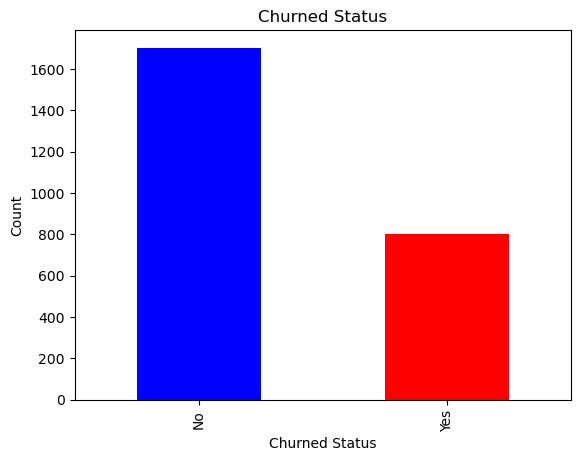

In [8]:
chruned_counts = data['churned_status'].value_counts()
chruned_counts.plot(kind='bar', color = ['blue', 'red'])
plt.title('Churned Status')
plt.xlabel('Churned Status')
plt.ylabel('Count')
plt.show()


`churned_status` is our target variable. Its binary and highly imbalanced, we have 2x times as many active as churned accounts.

## Data pre-processing

### Pro accounts

We will add new feature: `pro` which indicates whether the account was on the PRO plan at some point during data collection.

In [9]:
# pro = 1 if any of the PRO-plan actions are not null
# pro = 0 if all 3 PRO-plan actions are null
data['pro'] = np.where(data['action_gps_tracking'].isnull() & data['action_screenshots'].isnull() & data['action_create_custom_field'].isnull(), 0, 1)

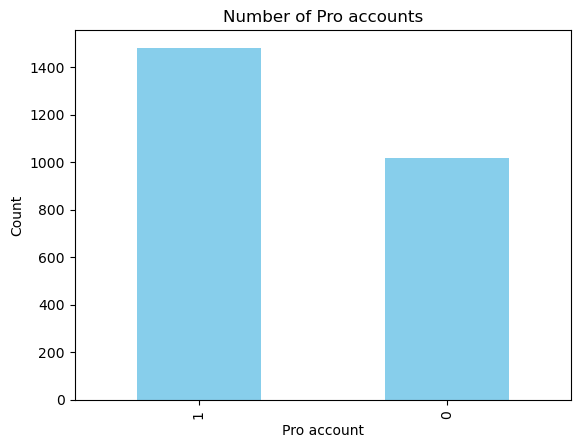

In [10]:
pro_counts = data['pro'].value_counts()
pro_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Pro account')
plt.ylabel('Count')
plt.title('Number of Pro accounts')
plt.show()

Majority of acccounts have been on the PRO plan at some point during data collection.

To test whether `pro` variable makes sense, we can run a quick linear regression to predict `revenue` based on the number of transcations made and `pro` variable.

If `pro` variable is significant, it means that it signifies higher revenue per transaction -- higher subscription price.

In [11]:
model = smf.ols('revenue ~ value_transactions_number + pro', data=data).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                     844.3
Date:                Fri, 26 Jan 2024   Prob (F-statistic):          7.34e-281
Time:                        15:48:27   Log-Likelihood:                -20207.
No. Observations:                2502   AIC:                         4.042e+04
Df Residuals:                    2499   BIC:                         4.044e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                  -465.1670     30.182    -15.412      0.000    -524.352    -405.982
value_transactions_number   129.1965      3.184     40.574      0.000     122.952     135.440
pro                         174.5353     31.701      5.506      0.000     112.372     236.698
==============================================================================
Omnibus:                     4522.950   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         10308746.506
Skew:                          12.613   Prob(JB):                         0.00
Kurtosis:                     316.446   Cond. No.                         19.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

`pro` is a significant predictor of `revenue` so we will include in the classification model.

###  Country recoding


We first recode us-states to "US" and then classify countries according to their continent and then merge continents into regions

In [13]:
data['countries2'] = data['country']
data.loc[data['countries2'].isin(us_states), 'countries2'] = 'USA'
data['continent'] = data['countries2'].apply(get_continent)

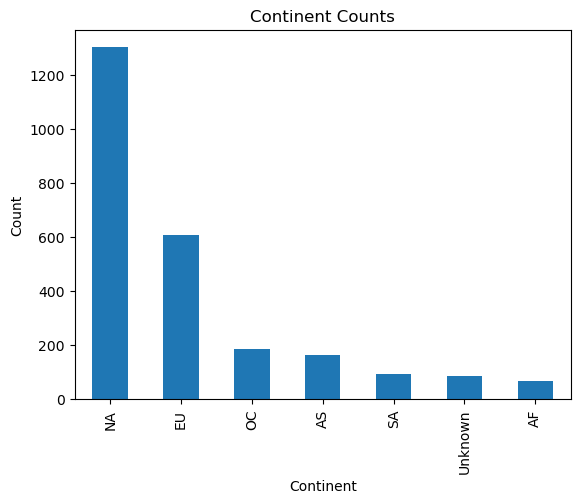

In [14]:
continent_counts = data['continent'].value_counts()
continent_counts.plot(kind='bar')
plt.xlabel('Continent')
plt.ylabel('Count')
plt.title('Continent Counts')
plt.show()

Majority of users are from North America, then EU and we merge others into "Rest of the world" category.

In [15]:
data['region'] = data['continent']
data.loc[data['region'].isin(['OC', 'AS', 'SA', 'Unknown', 'AF']), 'region'] = 'ROW'

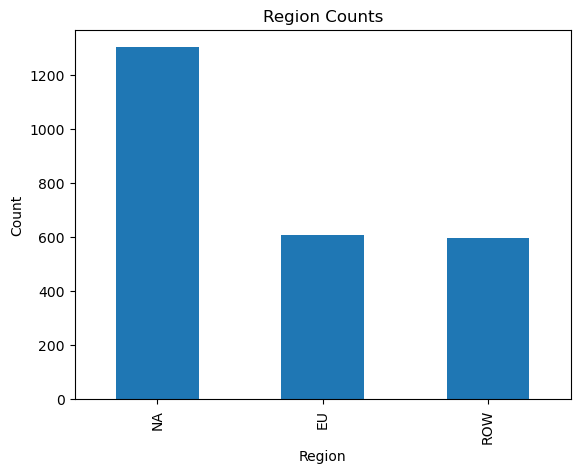

In [16]:
region_counts = data['region'].value_counts()
region_counts.plot(kind='bar')
plt.xlabel('Region')
plt.ylabel('Count')
plt.title('Region Counts')
plt.show()

This way we have a good balance between categories just three categories. Using NA vs Rest of the World would be ideally balanced, but we would lose information about differences between ROW and EU (purchasing power, language, etc.).

Finally, we recode the target to `churned` with value 1 for churned accounts and 0 for active accounts.


In [17]:
data['churn'] = np.where(data['churned_status'] == 'Yes', 1, 0)

## Churn classification

We will use logistic regression to predict churned accounts. It's a simple model with good interpretability, convenient feature importance ranking and it's easy to explain to non-technical audience.

We need to take several things into consideration.

1. Some of the features are clearly correlated, such as revenue ~ value_number_of_active_months OR value_number_of_transactions. We will need to use a smaller subset of features for the model to avoid multicollinearity and inflation of feature importance.
2. We have outliers in the activity record of the dataset, which might not represent the "true" user activity.
3. Scale of the numerical features is different. We will need to scale them to avoid numerical instability.
4. We have a highly imbalanced target variable. We need to use minority oversampling in the traning data to avoid overfitting to the majority class.

First step is to do one-hot encoding of the categorical variables. We encode `region` variable into three dummy variables: `region_eu`, `region_na` and `region_row`.

In [18]:
encoder = OneHotEncoder()
encoded_vars = encoder.fit_transform(data[['region']]).toarray()
encoded_vars = pd.DataFrame(encoded_vars, columns = ['region-eu','region-na', 'region-row'])

We remove the original categorical variable and add the dummy variables to the dataset. All features are now numerical.

In [19]:
data_encoded = data.drop(['region'], axis=1)
data_encoded = pd.concat([data, encoded_vars], axis=1)

To identify the outliers based on the number of users and action variables with large difference between max and 3rd quartile, we will run a simple OLS regression again.

We predict revenue based on the number of users and action variables. We will use the residuals of this regression to identify outliers using Cook's distance.

In [20]:
# OLS regression 
model = smf.ols('revenue ~ ws_users_activated + action_time_entries_via_tracker + action_create_invoice + action_create_project + action_export_report', data=data_encoded).fit()

# Get the influence statistics of observations
influence = model.get_influence()

# Extract Cook's distance of every observation
cooks_d2, pvals = influence.cooks_distance

cr = 4 / (len(data_encoded) - 2) # rule of thumb threshold

idx_outliers = np.where(cooks_d2 > cr)[0] # index of the outliers

# Dataset without outliers
data_encoded_out = data_encoded.drop(idx_outliers, axis=0).reset_index(drop=True)


We remove the outliers from the dataset. Now the max values of action variables are somewhat lower, so we didn't cut out all the outliers, but we removed the most extreme ones.

We have 2394 rows left in the dataset, we removed less than 5% of the data.


In [21]:
len(data_encoded_out)

2394

In [22]:
data_encoded_out.iloc[:, 0:14].describe()

,ws_users_activated,ws_users_deactivated,ws_users_invited,action_create_project,action_export_report,action_api_and_webhooks,action_time_entries_via_tracker,action_start_trial,action_import_csv,action_create_invoice,action_lock_entries,action_add_targets,action_connect_quickbooks,action_create_expense
count,2394.000000,2394.000000,2394.000000,2394.000000,2394.000000,2394.000000,2394.000000,2394.000000,2394.000000,2394.000000,2394.000000,2394.000000,2394.000000,2394.000000
mean,4.126566,0.610276,0.129908,22.147870,15.743108,0.270677,9.720969,0.173768,0.425647,6.332080,1.263158,0.254804,0.076023,8.356307
std,5.073577,2.173174,0.660699,51.969452,48.133724,1.132766,38.810886,0.378989,3.145401,27.222144,5.078581,1.272449,0.656754,63.057198
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,0.000000,0.000000,7.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.000000,0.000000,0.000000,24.000000,12.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
max,55.000000,41.000000,20.000000,1053.000000,1431.000000,17.000000,500.000000,1.000000,75.000000,673.000000,139.000000,30.000000,27.000000,1785.000000


### Select features

23 features are selected. We will use these features to predict `churned` variable.

In [23]:
y = data_encoded_out['churn']
X = data_encoded_out[['ws_users_activated', 'ws_users_deactivated', 'action_create_project', 'action_export_report', 'action_api_and_webhooks', 'action_import_csv','action_create_invoice','action_time_entries_via_tracker','action_create_invoice', 'action_lock_entries', 'action_add_targets', 'action_create_expense', 'action_project_budget', 'value_kiosk_seats','value_regular_seats', 'value_days_to_purchase', 'value_number_of_active_months', 'value_transactions_number',
'region-na', 'region-eu','region-row','pro', 'action_start_trial']]

We use a slightly larger test dataset because of the imbalance in the target variable. We will use 25% of the data for testing.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Scale features

We use standard scaler to scale the numerical features in the training and testing dataset. They are scaled to have mean 0 and standard deviation 1.

In [25]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### SMOTE

After scaling features, we run SMOTE to generate minority class samples in the training dataset. 

We make the training set more balanced. SMOTE uses 20 k-nearest neighbors to generate new samples. This provides more diversity of the training data so we don't overfit to the noise produced by small number of churned cases present in the data.

We only run SMOTE on the training data and leave the test data as it is. This is more realistic scenario and we assess the ability of the model to generalize outside of the training data.

In [26]:
smote = SMOTE(random_state=100, k_neighbors=20)
X_train_sm, y_train_sm = smote.fit_resample(X_train_scaled, y_train)

### Run model

We finally run and fit the model.

In [27]:
model = LogisticRegression(max_iter=1000)

In [28]:
model.fit(X_train_sm, y_train_sm)

LogisticRegression(max_iter=1000)

### Model performance

In [29]:
# Predict the test set results
y_pred = model.predict(X_test_scaled)

# Get the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

# Get the precision
precision = precision_score(y_test, y_pred)
print("Precision: ", precision)

# Get the F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score: ", f1)


Accuracy:  0.7195325542570952
Precision:  0.5270758122743683
F1 Score:  0.6347826086956522


Model achieves 0.72 accuracy, 0.52 precision and F1 score of 0.63.

This is moderate performance for a disbalanced dataset. We can see that the model is better at predicting the majority class (active accounts) than the minority class (churned accounts).

In [30]:
from sklearn.model_selection import cross_val_score

# Assuming 'model' is your logistic regression model
scores = cross_val_score(model, X, y, cv=10)

print("Cross-validated scores:", scores)
print("Average score:", scores.mean())

Cross-validated scores: [0.71666667 0.7125     0.69583333 0.73333333 0.74058577 0.77824268
 0.84518828 0.79916318 0.64016736 0.49790795]
Average score: 0.7159588563458856


Cross-validation mean score is 0.72, suggesting moderate performance of the model.

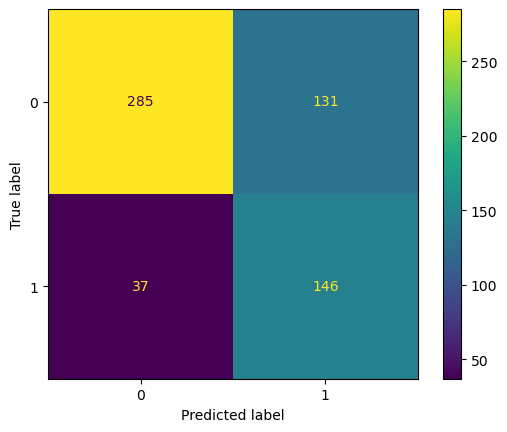

In [31]:
conf_mat = confusion_matrix(y_test, y_pred)


disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat) 
disp.plot() 
plt.show()


Confusion matrix shows that the model is better at predicting the majority class (active accounts) than the minority class (churned accounts).

Misclassification happens mostly when active accounts are predicted as churned accounts so in this case model errs on the side of caution.

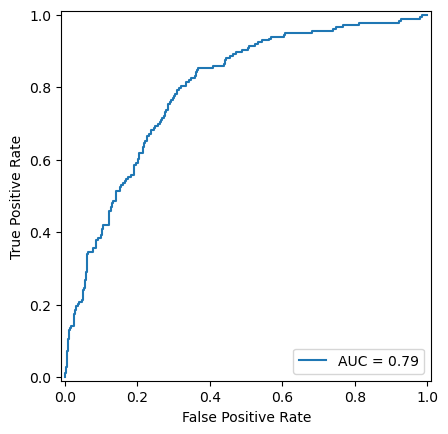

In [32]:
y_pred_proba = model.predict_proba(X_test_scaled)[:,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

# plot using RocCurveDisplay

disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc)
disp.plot()
plt.show()

Area under ROC curve is 0.79, meaning that in 79% of cases the model will correctly assign higher probability of churn to churned accounts than to active accounts.

Given the imbalance in the dataset, this points toward a balanced classification model.

### Feature importance

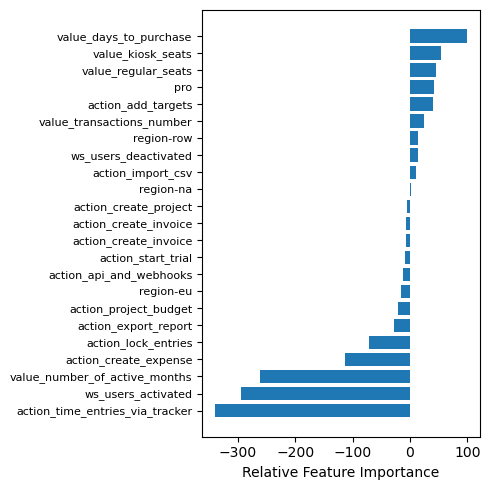

In [39]:
feature_importance = model.coef_[0]
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(5, 5))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()
plt.show()


Since the model is better at predicting the majority class (active accounts) than the minority class (churned accounts), this is also reflected in the feature importance ranking.

### Take-aways

For predicting active accounts, the most important features are volume of user activity and the utility Clockify provides: number of activated users, time entries, created expenses, locked entried, export reports, etc. Churn is also lower for EU users compared to ROW and NA users.

For predicting churn, there are several important predictors with interesting take-aways.

1. Number of days taken to pay for first subscription. The longer it takes the higher probability of churn becomes. These are probably users who are not sure whether Clockify provides enough value for their organization.
2. Paying for Pro plan. Users who bought Pro plan have higher probabilityu of churn.Probably users who are either not finding enough value in a Pro plan or they can't afford it.
3. Users from ROW. Users from ROW have higher probability of churn. Probably because of lower purchasing power and/or language barrier.

Since variables related to Adding targets, Kiosk mode and CSV are also related to higher probability of churn, it's possible that some of these features may have bugs or somehow detrimental effect on user experience.

To examine general importance of features for classification perfomance, we ran a permputation importance test.



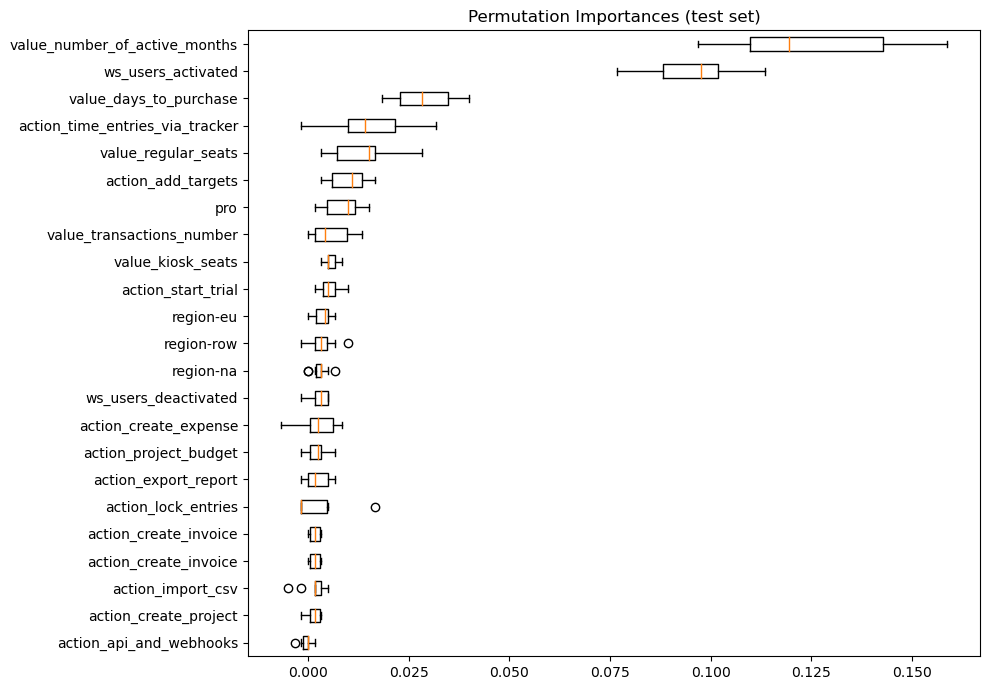

In [38]:
## plot feature_importance using permutation importance

from sklearn.inspection import permutation_importance

result = permutation_importance(model, X_test_scaled, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(10, 7))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=np.array(X.columns)[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()


This tells us that in terms of pure classification performance, number of active months and number of activated users are the most useful.

## Conclusion

We built a classification model to predict churned accounts. The model achieves 0.72 accuracy, 0.52 precision and F1 score of 0.63. Cross-validation mean score is 0.72 and AUC is 0.79. 

Overall, the model performs moderately well. It's better at predicting the majority class (active accounts) than the minority class (churned accounts). This is also reflected in the feature importance ranking.

Model perfomance could be artificially increased by running SMOTE on the entire dataset, but this would not be a realistic scenario. Also, missing data could be imputed, but we would loose the distinction between accounts on the PRO plan and accounts on the Basic/Standard plan.